<h1><center> Лабораторная работа №5(1) по курсу "Численные методы" </center></h1>
<h1><center> Решить начально-краевую задачу для дифференциального уравнения параболического типа. Явная и неявная конечно-разностные схемы и схема Кранка - Николсона. </center></h1>

|Студент| Марочкин И.А. |
|:-----:|:-:|
|Группа|М8О-406Б-19|
|Вариант|7|

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Граничные условия
def phi0(t: float, a: float, x = 0, ):
    return np.exp(-a * t)

def phil(t: float, a: float, x = np.pi):
    return -np.exp(-a * t)

# Начальные условия
def psi(x: float, t = 0):
    return np.sin(x)

# Аналитическое решение
def U(x: float, t: float, a: float) -> float:
    return np.exp(-a * t) * np.sin(x)

In [3]:
# Метод прогонки
def tma(a, b, c, d):
    size = len(a)
    p = np.zeros(size)
    q = np.zeros(size)
    p[0] = -c[0] / b[0]
    q[0] = d[0] / b[0]

    for i in range(1, size):
        p[i] = -c[i] / (b[i] + a[i] * p[i - 1])
        q[i] = (d[i] - a[i] * q[i - 1]) / (b[i] + a[i] * p[i - 1])

    x = np.zeros(size)
    x[-1] = q[-1]

    for i in range(size - 2, -1, -1):
        x[i] = p[i] * x[i + 1] + q[i]

    return x

In [4]:
def explicit(a: float, n: int, tc: int, tau: float, x_min: float, x_max: float, al: int):
    """
    Явная конечно-разностная схема
    :param a: коэффициент температуропровдности
    :param n: количество точек в пространстве
    :param tc: количество временных точек
    :param tau: временной шаг
    :param x_min: левая граница
    :param x_max: правая граница
    :param al: тип апроксимации
        al = 1: двухточечная аппроксимация с первым порядком
        al = 2: двухточечная аппроксимация со вторым порядком
        al = 3: трехточечная аппроксимация со вторым порядком
    :return: сеточную функцию
    """

    h = (x_max - x_min) / n
    sigma = a ** 2 * tau / h ** 2

    if sigma > 0.5:
        raise Exception(f'Явная схема не устойчива sigma = {sigma}')
    u = np.zeros((tc, n))

    for j in range(1, n - 1):
        u[0][j] = psi(x_min + j * h)

    for k in range(1, tc):
        for j in range(1, n - 1):
            u[k][j] = sigma * (u[k - 1][j + 1] + u[k - 1][j - 1]) + (1 - 2 * sigma) * u[k - 1][j]
        if al == 1:
            u[k][0] = u[k][1] - h * phi0(k * tau, a)
            u[k][-1] = u[k][-2] + h * phil(k * tau, a)
        elif al == 2:
            u[k][0] = (u[k][1] - h * phi0(k * tau, a) + (h ** 2 / (2 * tau) * u[k - 1][0])) / (1 + h ** 2 / (2 * tau))
            u[k][-1] = (u[k][-2] + h * phil(k * tau, a) + (h ** 2 / (2 * tau) * u[k - 1][-1])) / (1 + h ** 2 / (2 * tau))
        elif al == 3:
            u[k][0] = (phi0(k * tau, a) + u[k][2] / (2 * h) - 2 * u[k][1] / h) * 2 * h / -3
            u[k][-1] = (phil(k * tau, a) - u[k][-3] / (2 * h) + 2 * u[k][-2] / h) * 2 * h / 3
        else:
            raise Exception('Такого типа апроксимации граничных условий не существует')

    return u

In [5]:
def explicit_implicit(ap: float, n: int, tc: int, tau: float, x_min: float, x_max: float, al: int, eta = 0.5):
    """
    Явно-неявная конечно-разностная схема
    :param a: коэффициент температуропровдности
    :param n: количество точек в пространстве
    :param tc: количество временных точек
    :param tau: временной шаг
    :param x_min: левая граница
    :param x_max: правая граница
    :param al: тип апроксимации
        al = 1: двухточечная аппроксимация с первым порядком
        al = 2: двухточечная аппроксимация со вторым порядком
        al = 3: трехточечная аппроксимация со вторым порядком
    :param eta: коэффициет
    :return: сеточную функцию
    """

    u = np.zeros((tc, n))
    h = (x_max - x_min) / n
    sigma = ap ** 2 * tau / h ** 2

    for i in range(1, n - 1):
        u[0][i] = psi(x_min + i * h)

    for k in range(1, tc):
        a = np.zeros(n)
        b = np.zeros(n)
        c = np.zeros(n)
        d = np.zeros(n)
        for j in range(1, n - 1):
            a[j] = sigma
            b[j] = -(1 + 2 * sigma)
            c[j] = sigma
            d[j] = -u[k - 1][j]

        # Аппроксимация граничных условий неявной схемы
        if al == 1:
            b[0] = -1 / h
            c[0] = 1 / h
            d[0] = phi0((k + 1) * tau, ap)
            a[-1] = -1 / h
            a[-1] = 1 / h
            d[-1] = phil((k + 1) * tau, ap)
        elif al == 2:
            b[0] = 2 * ap ** 2 / h + h / tau
            c[0] = - 2 * ap ** 2 / h
            d[0] = (h / tau) * u[k - 1][0] - phi0((k + 1) * tau, ap) * 2 * ap ** 2
            a[-1] = -2 * ap ** 2 / h
            b[-1] = 2 * ap ** 2 / h + h / tau
            d[-1] = (h / tau) * u[k - 1][-1] + phil((k + 1) * tau, ap) * 2 * ap ** 2
        elif al == 3:
            k0 = 1 / (2 * h) / c[1]
            b[0] = (-3 / (2 * h) + a[1] * k0)
            c[0] = 2 / h + b[1] * k0
            d[0] = phi0((k + 1) * tau, ap) + d[1] * k0
            k1 = -(1 / (h * 2)) / a[-2]
            a[-1] = (-2 / h) + b[-2] * k1
            b[-1] = (3 / (h * 2)) + c[-2] * k1
            d[-1] = phil((k + 1) * tau, ap) + d[-2] * k1
        else:
            raise Exception('Такого типа апроксимации граничных условий не существует')

        # Решение неявной схемой
        u[k] = eta * tma(a, b, c, d)

        # Решение явной схемой
        explicit_part = np.zeros(n)

        # Аппроксимация граничных условий явной схемы
        for j in range(1, n - 1):
            explicit_part[j] = (sigma * (u[k - 1][j + 1] + u[k - 1][j - 1]) + (1 - 2 * sigma) * u[k - 1][j])
        if al == 1:
            explicit_part[0] = (explicit_part[1] - h * phi0(k * tau, ap))
            explicit_part[-1] = (explicit_part[-2] + h * phil(k * tau, ap))
        elif al == 2:
            explicit_part[0] = ((phi0(k * tau, ap) + explicit_part[2] / (2 * h) - 2 * explicit_part[1] / h) * 2 * h / -3)
            explicit_part[-1] = ((phil(k * tau, ap) - explicit_part[-3] / (2 * h) + 2 * explicit_part[-2] / h) * 2 * h / 3)
        elif al == 3:
            explicit_part[0] = (explicit_part[1] - h * phi0(k * tau, ap) + (h ** 2 / (2 * tau) * u[k - 1][0])) / \
                               (1 + h ** 2 / (2 * tau))
            explicit_part[-1] = (explicit_part[-2] + h * phil(k * tau, ap) + (h ** 2 / (2 * tau) * u[k - 1][-1])) / \
                                (1 + h ** 2 / (2 * tau))
        else:
            raise Exception('Такого типа апроксимации граничных условий не существует')

        u[k] += (1 - eta) * explicit_part

    return u

In [6]:
def draw_results(tc, x_max, x_min, u, a):
    """
    Построение графиков
    :param tc: количество временных точек
    :param x_max: правая граница
    :param x_min: левая граница
    :param u: сеточная функция
    :param a: коэффициент температуропровдности
    """

    times = np.zeros(tc)
    
    for i in range(tc):
        times[i] = tau * i
    
    space = np.zeros(n)
    step = (x_max - x_min) / n
    
    for i in range(n):
        space[i] = x_min + i * step

    times_idx = np.linspace(0, times.shape[0] - 1, 6, dtype = np.int32)
    fig, ax = plt.subplots(3, 2)
    fig.suptitle('Сравнение решений')
    fig.set_figheight(15)
    fig.set_figwidth(16)
    k = 0
    
    for i in range(3):
        for j in range(2):
            time_idx = times_idx[k]
            ax[i][j].plot(space, u[time_idx], label = 'Численный метод')
            ax[i][j].plot(space, [U(x, times[time_idx], a) for x in space], label = 'Аналитическое решение')
            ax[i][j].grid(True)
            ax[i][j].set_xlabel('x')
            ax[i][j].set_ylabel('t')
            ax[i][j].set_title(f'Решения при t = {times[time_idx]}')
            k += 1
    plt.legend(bbox_to_anchor = (1.05, 2), loc = 'upper left', borderaxespad = 0.)
    error = np.zeros(tc)
    for i in range(tc):
        error[i] = np.max(np.abs(u[i] - np.array([U(x, times[i], a) for x in space])))
    plt.figure(figsize = (12, 7))
    plt.plot(times[1:], error[1:], 'violet', label = 'Ошибка')
    plt.legend(bbox_to_anchor = (1.05, 1), loc = 'upper left', borderaxespad = 0.)
    plt.title('График изменения ошибки во времени')
    plt.xlabel('t')
    plt.ylabel('error')
    plt.grid(True)
    plt.show()

## Тестирование

### Явная конечно-разностная схема

In [7]:
a = 1
n = 60
tc = 2000
tau = 0.001
x_min, x_max = 0, np.pi
u = explicit(a = a, n = n, tc = tc, tau = tau, x_min = x_min, x_max = x_max, al = 1)
u

array([[ 0.00000000e+00,  5.23359562e-02,  1.04528463e-01, ...,
         1.56434465e-01,  1.04528463e-01,  0.00000000e+00],
       [-2.39116110e-05,  5.22836322e-02,  1.04423959e-01, ...,
         1.56278066e-01,  8.53340910e-02,  3.30265471e-02],
       [-3.26238105e-05,  5.22226386e-02,  1.04319559e-01, ...,
         1.49158675e-01,  9.21318460e-02,  3.98765836e-02],
       ...,
       [-1.07705291e-03,  6.03037628e-03,  1.31171653e-02, ...,
         1.90090185e-02,  1.19395622e-02,  4.83213299e-03],
       [-1.07747767e-03,  6.02284765e-03,  1.31025528e-02, ...,
         1.89881024e-02,  1.19257114e-02,  4.82538604e-03],
       [-1.07790223e-03,  6.01532631e-03,  1.30879547e-02, ...,
         1.89672074e-02,  1.19118746e-02,  4.81864605e-03]])

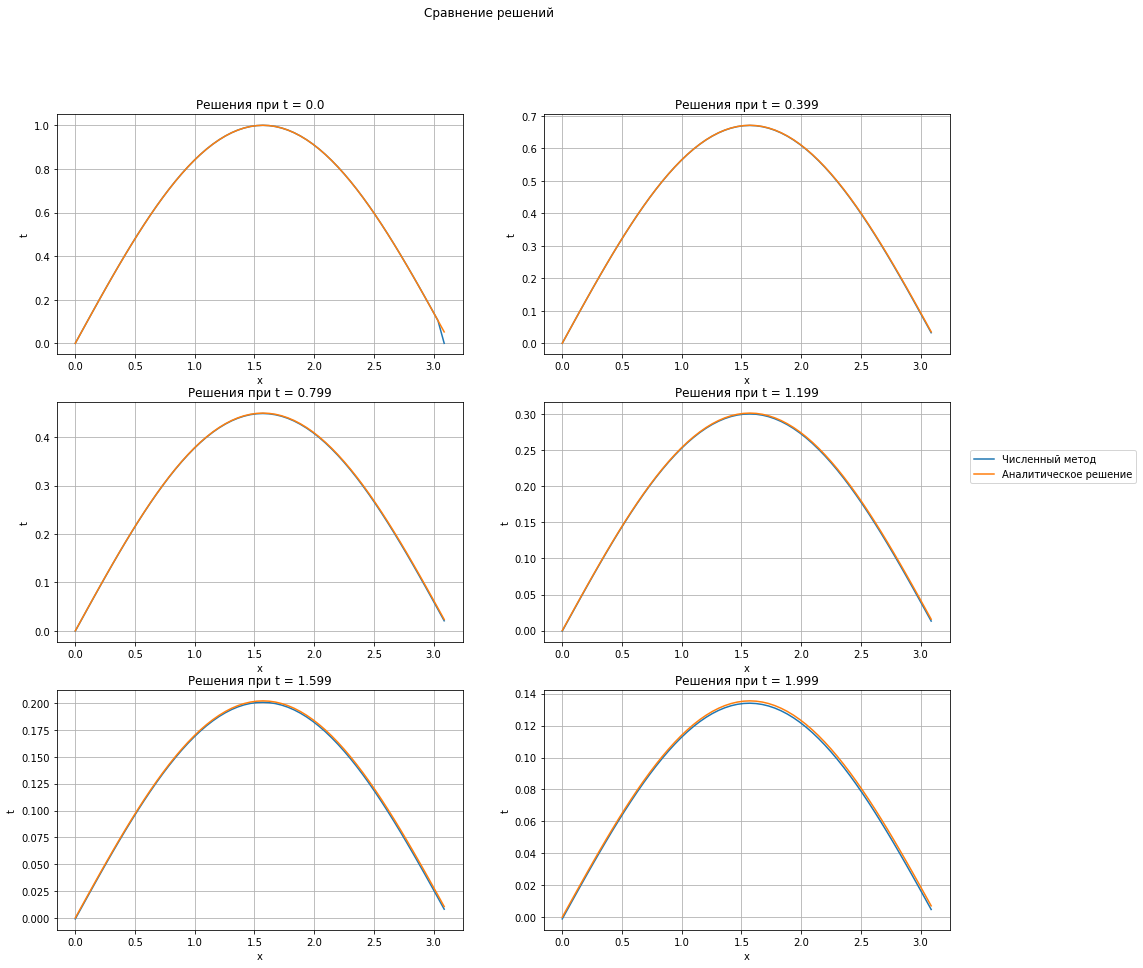

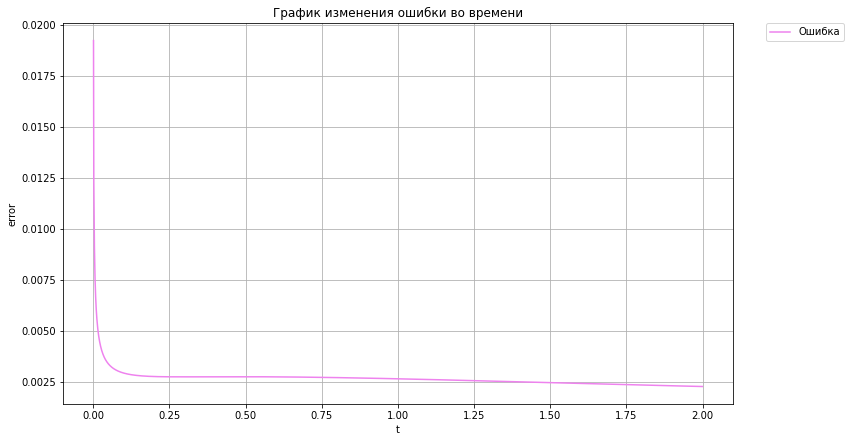

In [8]:
draw_results(tc, x_max, x_min, u, a)

### Неявная конечно-разностная схема

In [9]:
a = 1
n = 80
tc = 2000
tau = 0.001
x_min, x_max = 0, np.pi
u = explicit_implicit(ap = a, n = n, tc = tc, tau = tau, x_min = x_min, x_max = x_max, al = 2, eta = 1)
u

array([[0.00000000e+00, 3.92598158e-02, 7.84590957e-02, ...,
        1.17537397e-01, 7.84590957e-02, 0.00000000e+00],
       [1.99443785e-05, 3.92267696e-02, 7.83826335e-02, ...,
        1.15438334e-01, 7.19744258e-02, 1.85103420e-02],
       [3.26882821e-05, 3.91947896e-02, 7.83075738e-02, ...,
        1.13945456e-01, 7.08284488e-02, 2.59442012e-02],
       ...,
       [5.27061146e-04, 5.85224413e-03, 1.11690888e-02, ...,
        1.60654706e-02, 1.07602698e-02, 5.43897023e-03],
       [5.26982040e-04, 5.84684245e-03, 1.11583728e-02, ...,
        1.60497392e-02, 1.07498409e-02, 5.43385990e-03],
       [5.26902949e-04, 5.84144611e-03, 1.11476674e-02, ...,
        1.60340237e-02, 1.07394225e-02, 5.42875474e-03]])

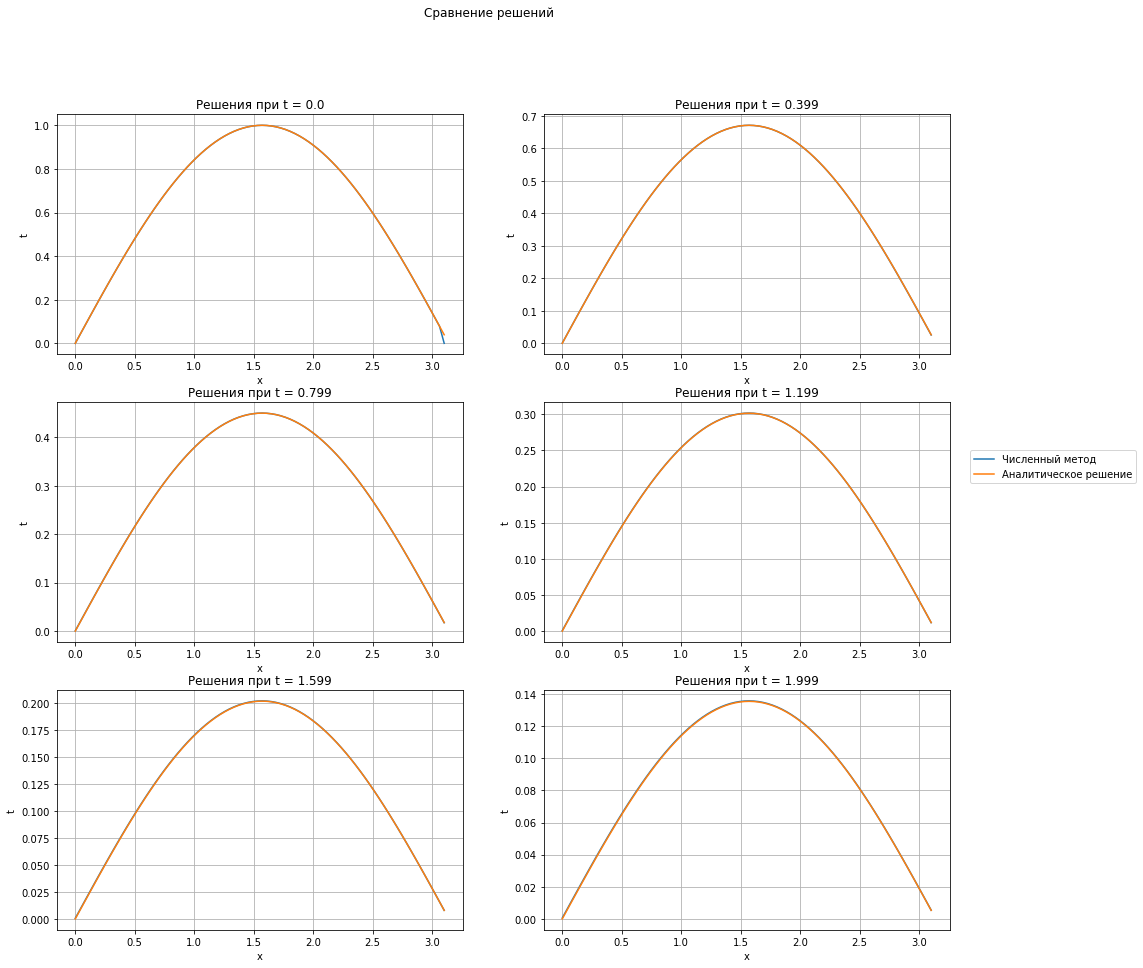

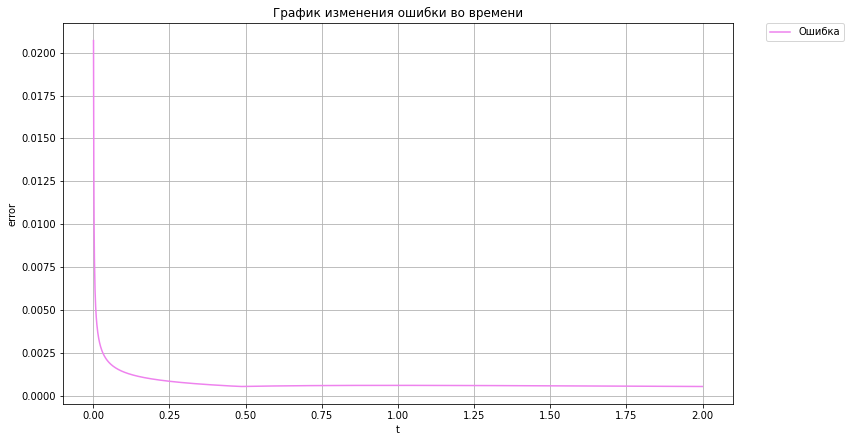

In [10]:
draw_results(tc, x_max, x_min, u, a)

### Явно-неявная конечно-разностная схема

In [11]:
a = 1
n = 80
tc = 2000
tau = 0.0001
x_min, x_max = 0, np.pi
u = explicit_implicit(ap = a, n = n, tc = tc, tau = tau, x_min = x_min, x_max = x_max, al = 3, eta = 0.5)
u

array([[0.00000000e+00, 3.92598158e-02, 7.84590957e-02, ...,
        1.17537397e-01, 7.84590957e-02, 0.00000000e+00],
       [8.11206829e-06, 3.92563910e-02, 7.84512800e-02, ...,
        1.17525638e-01, 7.71782099e-02, 2.17288514e-02],
       [1.20696057e-05, 3.92531889e-02, 7.84434919e-02, ...,
        1.17437383e-01, 7.67094297e-02, 3.05573969e-02],
       ...,
       [2.49543674e-04, 3.23864735e-02, 6.44732840e-02, ...,
        9.60256151e-02, 6.40136532e-02, 3.19016749e-02],
       [2.49593783e-04, 3.23833099e-02, 6.44669116e-02, ...,
        9.60160146e-02, 6.40072541e-02, 3.18984871e-02],
       [2.49643870e-04, 3.23801467e-02, 6.44605397e-02, ...,
        9.60064151e-02, 6.40008557e-02, 3.18952995e-02]])

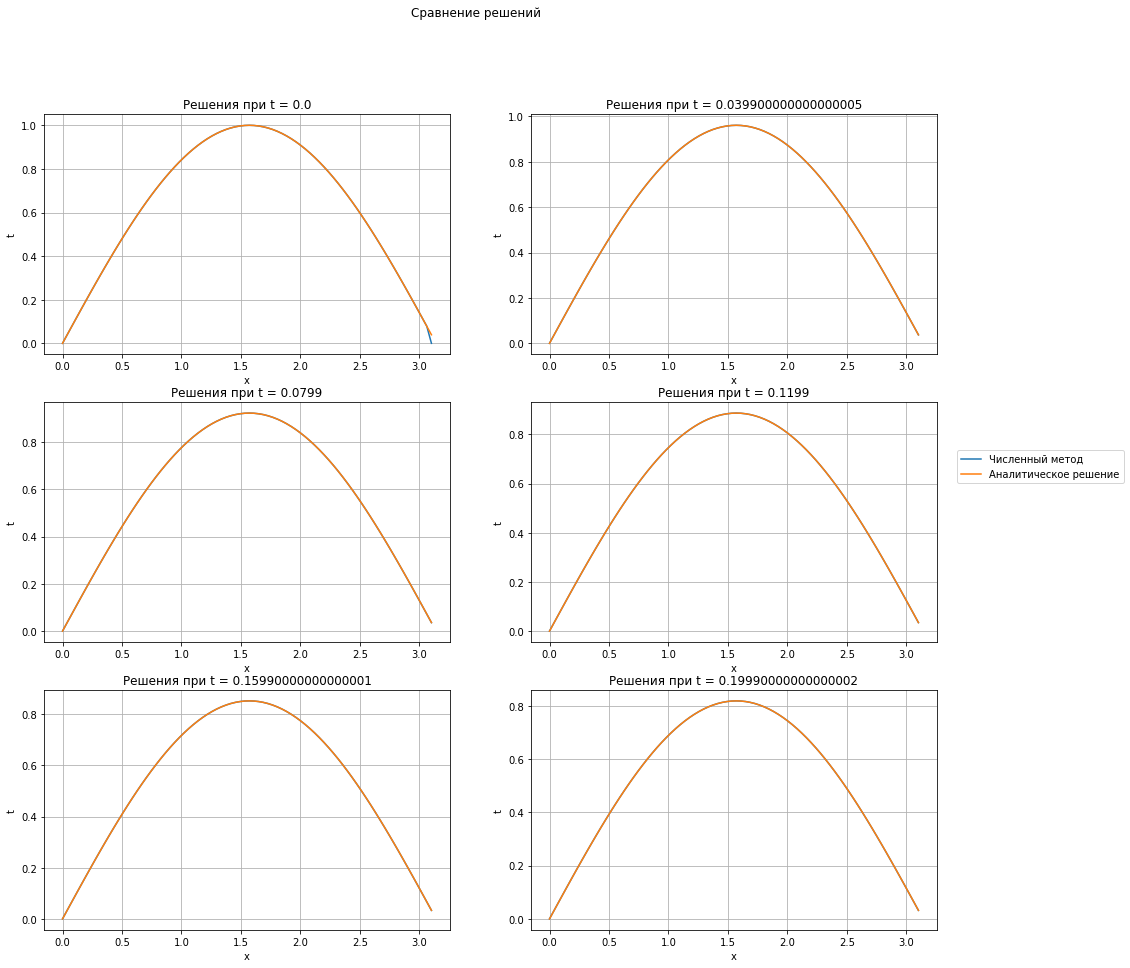

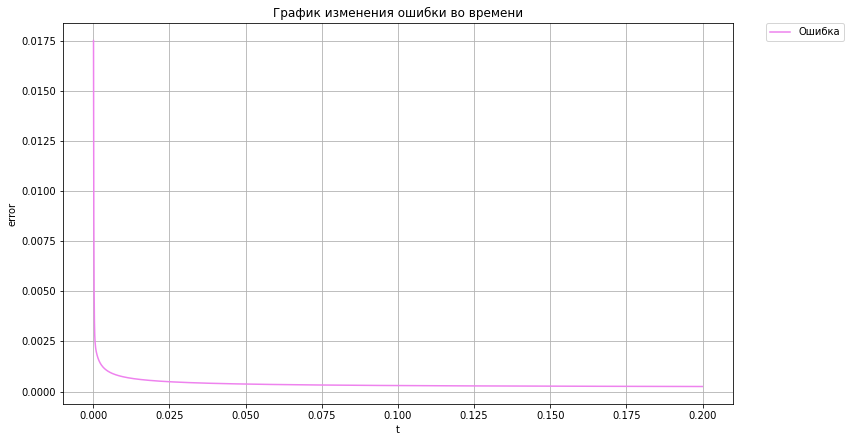

In [12]:
draw_results(tc, x_max, x_min, u, a)